# DevTool: Lattice3D
<hr><br>
Developers' tools iPython Notebook for the Lattice3D object

In [1]:
%matplotlib inline
#
from lrgsglib.core import *
#
move_to_rootf()
plt.style.use(os.path.join('ipynb', 'nb_plotsheet.mplstyle'))
#
datpath = os.path.join('ipynb', 'data')
#
kwargL3D = dict(dataOut=datpath)

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


## Basic Visualization

### Edge colors and fixed positions

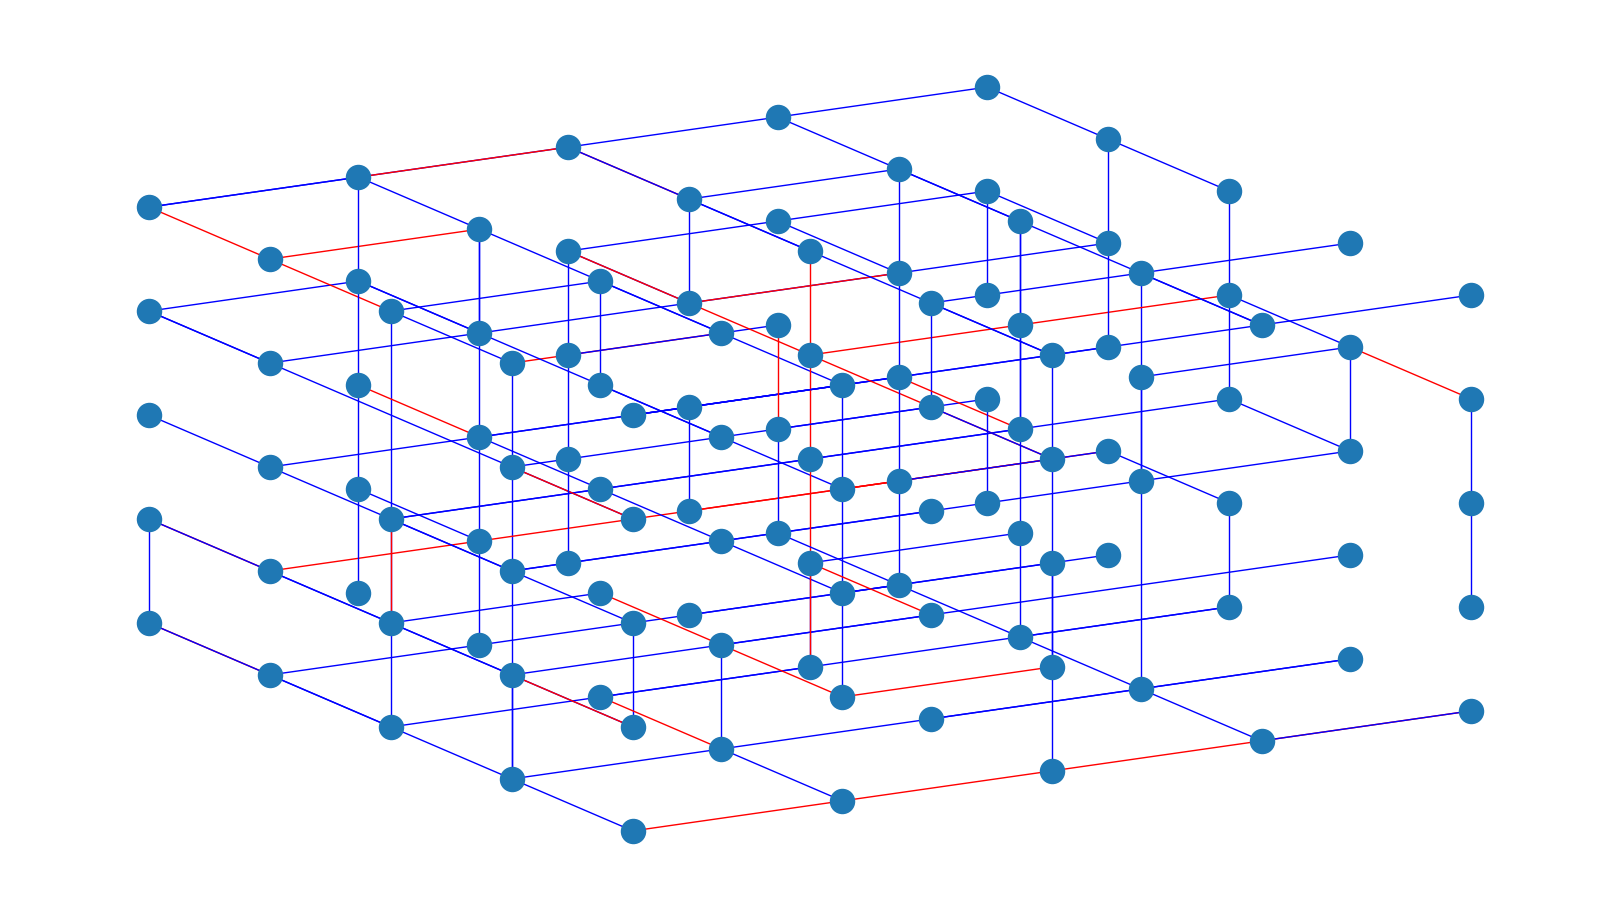

In [18]:
side = 5
pflip = 0.2
pdil = 0.6
#
l3 = Lattice3D(side, pflip=pflip, pdil=pdil, with_positions=True, **kwargL3D)
l3.flip_random_fract_edges()
#
nx.draw(l3.G, pos=l3.get_node_attributes('pos'), 
        edge_color=l3.get_edge_color())

## Developing

### ND BCC

In [ ]:
import networkx as nx
from itertools import product
from typing import Union, Tuple, List

# Cartesian Product Iterator for generating all nodes in the n-dimensional grid
def cProd_Iter(dim: Union[int, Tuple]) -> iter:
    return product(*[range(d) for d in dim])

# Cartesian Product Iterator for selected dimensions in the n-dimensional grid
def cProdSel_Iter(dim: Union[int, Tuple], selected_indices: Union[List, Tuple]) -> iter:
    ranges = [range(dim[i]) for i in selected_indices]
    return product(*ranges)

# Function to generate an N-dimensional BCC lattice with periodic boundaries
def LatticeND_graph_FastPatch(dim: Tuple[int, ...], periodic: bool = False):
    """
    Generates an N-dimensional Body-Centered Cubic (BCC) lattice graph with optional periodic boundary conditions.

    Parameters
    ----------
    dim : tuple of int
        A tuple where each element specifies the size of the grid along a particular dimension.
        For example, (2, 3, 4) represents a 3D grid with dimensions 2x3x4.

    periodic : bool
        If True, apply periodic boundary conditions along all dimensions.

    Returns
    -------
    NetworkX Graph
        An N-dimensional BCC lattice graph.
    """
    # Raise an error if there's a dimension of size 2 in a 2D grid
    if len(dim) == 2 and 2 in dim:
        raise ValueError("A dimension of size 2 in a 2D grid can cause incorrect periodic edge handling.")

    G = nx.Graph()  # Create an empty undirected graph
    num_dimensions = len(dim)

    # Generate all nodes in the grid
    nodes = list(cProd_Iter(dim))
    G.add_nodes_from(nodes)

    # Add nodes in the center of each hyperface (BCC nodes)
    for pt in nodes:
        # Create new BCC nodes by adding 0.5 to some of the coordinates, keeping at least one coordinate the same
        for mask in product([0, 0.5], repeat=num_dimensions):
            if sum(mask) == 0.5 * (num_dimensions - 1):
                bcc_node = tuple(d + offset for d, offset in zip(pt, mask))
                # Ensure the BCC node is within the valid dimension range
                if all(0 <= n < dim[i] for i, n in enumerate(bcc_node)):
                    G.add_node(bcc_node)
                    # Connect the BCC node to the original point
                    G.add_edge(pt, bcc_node)

    # Direction vectors for creating edges to neighboring nodes (standard cubic lattice)
    e_i = [tuple(1 if i == j else 0 for j in range(num_dimensions)) for i in range(num_dimensions)]

    # Add edges between each node and its neighbors, including periodic boundaries if required
    for pt in nodes:
        # Standard edges to neighboring nodes
        for drt in e_i:
            # Calculate the neighbor's coordinates by adding the direction vector
            neighbor = tuple((d + p) for d, p in zip(pt, drt))
            # Handle non-periodic boundaries
            if all(0 <= n < dim[i] for i, n in enumerate(neighbor)):
                G.add_edge(pt, neighbor)
            # Handle periodic boundaries if enabled
            elif periodic:
                neighbor = tuple((n % dim[i]) for i, n in enumerate(neighbor))
                G.add_edge(pt, neighbor)

    return G

# Example usage
dim = (3, 3, 3)  # Dimensions for a 3x3 grid
periodic = True  # Set to True for periodic boundary conditions
G = LatticeND_graph_FastPatch(dim, periodic)

# Output some properties of the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
from lrgsglib.config.utils import project_3d_to_2d
pos = {node: project_3d_to_2d(*node, theta=np.pi/3, phi=np.pi/4) for node in G.nodes()}

### Degree sequence check

In [ ]:
expectedDegrees = 6
degree_count = {node: 0 for node in l.G.nodes()}
# Iterate over all edges in the graph
for u, v, data in l.G.edges(data=True):
    # Check if the edge is of the desired type
    degree_count[u] += 1
    degree_count[v] += 1
# degree_count now contains the degree of each node based on type 1 links only
print(np.where(np.array(list(degree_count.values())) != expectedDegrees)[0])

In [ ]:
class LatticeGenerator:
    def __init__(self, dim, pbc=True):
        self.dim = dim
        self.pbc = pbc

    def _wrap_coordinate(self, coord):
        """Wrap coordinates according to PBC and lattice dimensions."""
        return tuple(c % d for c, d in zip(coord, self.dim))

    def _generate_fcc_lattice(self):
        G = nx.Graph()
        
        # Offsets for FCC lattice to include face-centered points
        fcc_offsets = [(0, 0, 0), (0.5, 0.5, 0), (0.5, 0, 0.5), (0, 0.5, 0.5)]

        # Generate all nodes, considering PBC for wrapping
        nodes = set(self._wrap_coordinate((x + ox, y + oy, z + oz))
                    for x, y, z in product(range(self.dim[0]), range(self.dim[1]), range(self.dim[2]))
                    for ox, oy, oz in fcc_offsets)

        G.add_nodes_from(nodes)

        # Pre-calculate wrapped neighbors for each node considering PBC
        node_list = list(G.nodes())
        for nd in node_list:
            for ox, oy, oz in fcc_offsets:
                for dx, dy, dz in [(-0.5, -0.5, 0), (-0.5, 0.5, 0), (0.5, -0.5, 0), (0.5, 0.5, 0),
                                   (-0.5, 0, -0.5), (-0.5, 0, 0.5), (0.5, 0, -0.5), (0.5, 0, 0.5),
                                   (0, -0.5, -0.5), (0, -0.5, 0.5), (0, 0.5, -0.5), (0, 0.5, 0.5)]:
                    # Wrap neighbor coordinates considering PBC
                    neighbor = self._wrap_coordinate((nd[0] + ox + dx, nd[1] + oy + dy, nd[2] + oz + dz))
                    if neighbor in nodes and neighbor != nd:
                        G.add_edge(nd, neighbor)

        return G

# Example usage
dim = (4, 4, 4)  # Specify dimensions of the FCC lattice
lattice_gen = LatticeGenerator(dim)
G = lattice_gen._generate_fcc_lattice()

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

## Tools

### Cluster distribution

In [ ]:
# init
side = 10
pflip = 0.19
nAvg = 100
distDict = Counter()
#
np.random.seed(0)
random.seed(0)

In [ ]:
# run
for _ in range(nAvg):
    l = Lattice3D(side, pflip=pflip, sgpath="test_data/")
    l.flip_random_fract_edges()
    distDict += l.cluster_distribution()
#
basename = f"clusterDistribution_p={pflip:.3g}_na={nAvg}.pkl"
fname = os.path.join(l.lrgsgpath, basename)
with open(fname, 'wb') as f:
    pk.dump(distDict, f)

In [ ]:
# load and prepare
test = pk.load(open(fname, 'rb'))
k,v  = unzip_dict_items(test)
arr = np.repeat(k, v)
x, pdf = powerlaw.pdf(arr)

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(7, 3.5))
#
ax.loglog(x[1:], pdf)
ax.loglog(x[1:], x[1:]**(-2.18))
#
ax.set_xlabel(r"$S$")
ax.set_ylabel(r"$P(S)$")
#
fig.tight_layout()

### Network representation

In [36]:
# init
side = 4
geo = 'sc'
#
pflip = 0.4
theta = np.pi/3
phi = np.pi/6
kwargs = dict(pflip=pflip, theta=theta, phi=phi, with_positions=True, sgpath="test_data/")

In [37]:
# computations
l = Lattice3D(side, geo, **kwargs)
l.flip_random_fract_edges()
l.load_eigV_on_graph(binarize=True)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
edgeColrs = ['blue' if l.G[u][v]['weight'] > 0 else 'r' 
             for u, v in l.G.edges()]
nx.draw(l.G, ax=ax, pos=l.get_node_pos(), edge_color=edgeColrs, cmap='red_blue', 
        width=2, node_size=100, node_color=l.get_node_attr('eigV0'), 
        linewidths=0.5, edgecolors='k')